# Fetal Partial Pathlength Distribution
In this notebook, we look at how the fetal partial pathlength (L4 ppath) is distributed accross different wavelengths and specifically different depths. The goal is to figure out a binning such that we can use it in a physics-based loss scenerio. Ideally, I would expect to bin $exp(-L_4)$ rather than $L_4$ itself and also for the model to figure out the bin centers. But that might be too high of an expectation.

In [2]:
from pathlib import Path
from glob import glob
import pandas as pd
import json

raw_file_path = Path(r'/home/rraiyan/simulations/tfo_sim/data/dan_iccps_pencil2')

raw_files = list(raw_file_path.glob("*.pkl"))  # RAW files are in pickle format
raw_files = [Path(file) for file in raw_files]

file1 = raw_files[15]
config1 = file1.with_suffix('.json')
raw_data1 = pd.read_pickle(file1)
with open(config1) as f:
    config_data1 = json.load(f)

In [3]:
from tfo_sim.misc import generate_sdd_column

sdd_col = generate_sdd_column(raw_data1).astype(int)
all_sdd = sdd_col.unique()
all_sdd.sort()
print(all_sdd)

[10 15 19 24 28 33 37 41 46 50 55 59 64 68 72 77 81 86 90 94]


In [4]:
chosen_sdd = 19
raw_data1 = raw_data1[sdd_col == chosen_sdd]
l4_col = raw_data1['L4 ppath']
print("Non zero values: ", l4_col.shape[0])

Non zero values:  6308202


# Looking at the Distributions With A Large Bin Count
How does the $L_4# and $exp(-L_4)$ distribution look like when using a very large bin count. This gives us a general idea of how the plots should look like and how to go about bringing the bin sizes down

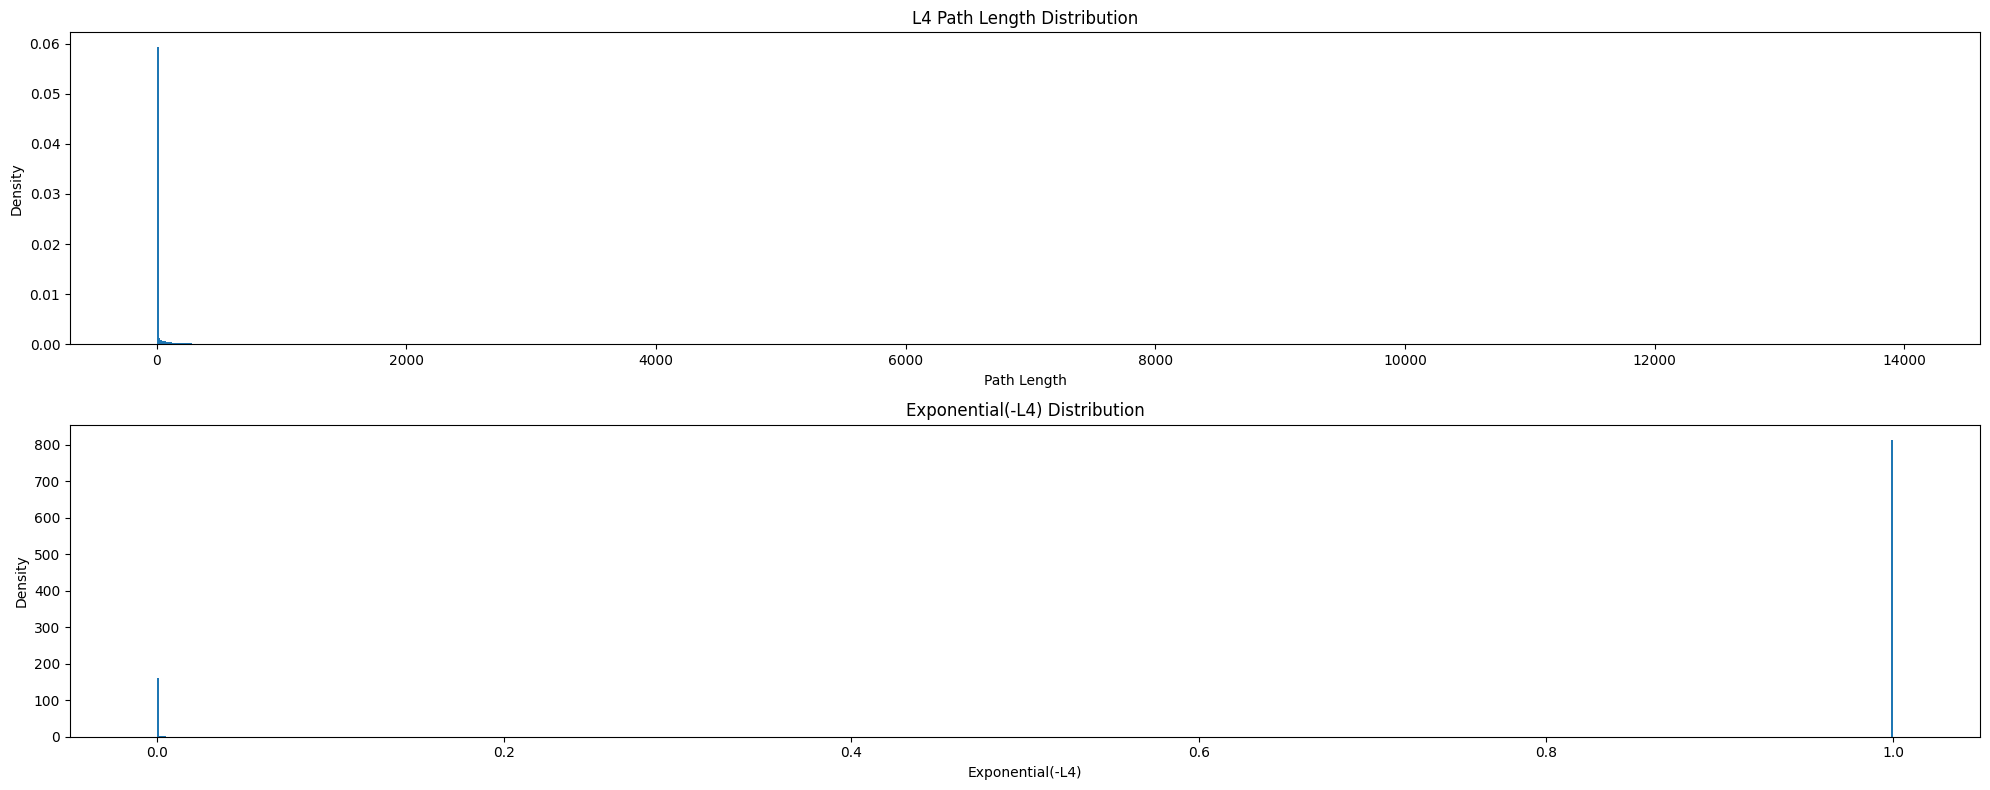

In [5]:
import numpy as np
import matplotlib.pyplot as plt

BIN_COUNT = 1000

dist_fig, axes = plt.subplots(2, 1, figsize=(20, 8))
axes[0].hist(l4_col, bins=BIN_COUNT, density=True)
axes[0].set_title("L4 Path Length Distribution")
axes[0].set_xlabel("Path Length")
axes[0].set_ylabel("Density")

exp_neg_l4 = np.exp(-l4_col)
exp_neg_l4 = exp_neg_l4[exp_neg_l4 > 0]
axes[1].hist(exp_neg_l4, bins=BIN_COUNT, density=True)
axes[1].set_title("Exponential(-L4) Distribution")
axes[1].set_xlabel("Exponential(-L4)")
axes[1].set_ylabel("Density")
plt.tight_layout()
plt.show()

# Plotting the Log of the Distribution
Often times with photon count related problems, the log of the distribution might be better behaved than the raw distribution itself. However, this does not seem to be the case here! Notice the weird curvature. Though it might not be such a bad idea fitting the curve while keeping the distribution at the 0 bin separate

/tmp/ipykernel_1237799/129299255.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(bin_centers, np.log(dist), 'x')


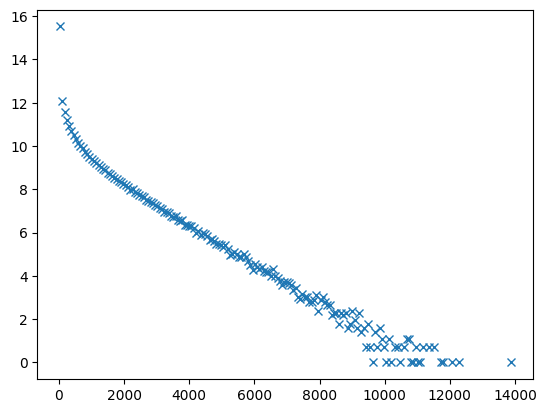

In [6]:
# The L4 dist looks like a decaying exponential distribution - which means taking the log should produce a linear distribution
dist, bin_edges = np.histogram(l4_col, bins=200)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# dist = dist / np.sum(dist)
plt.plot(bin_centers, np.log(dist), 'x')

# Comparing $\sum exp(-\mu_a \times L_4)$ Calculated With/Without Histrogram
Our ultimate goal is to estimate this sum term using histogrammed values. We want it to match the true values(i.e., calculated directly without binning) as closely as possible.

In [7]:
# comparing actual sum vs. histogram sum in EXP mode
mu = 0.04   # mm-1 (an expected value)
print("Actual sum: ", np.power(exp_neg_l4, mu).sum())

dist, bin_edges = np.histogram(np.power(exp_neg_l4, mu), bins=100)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
print("Histogram sum: ", (dist * bin_centers).sum())

Actual sum:  5245991.88155585
Histogram sum:  5223053.675000102


In [8]:
# Comparing actual sum vs. histogram sum in L4 mode
print("Actual sum: ", np.exp(-mu * l4_col).sum())

dist, bin_edges = np.histogram(l4_col, bins=1000)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
print("Histogram sum: ", (dist * np.exp(-mu * bin_centers)).sum())

Actual sum:  5245991.881555854
Histogram sum:  4026593.2810565326


## Friendly Comments
1. Storing $exp(-L_4 * \mu_a)$ gives the best results. The errors are in the third most significant digit. Which is probably as good as we will get. However, obviously we cannot store these values. Since the $\mu_a$ would need to be predicted by the model and provided externally wrt our equations. 
2. Storing $exp(-L_4)$ produces too large of an error when calculating $exp(-\mu \times L_4)$ due to just how much the exponents spread after applying the power! Even with 20k-ish bins, the approximation in true sum and binned sum had a magnitude difference in values. Which again makes sense given the large bins in linear scale. 
3. Storing plane $L-4$ is still bad. Using roughly a 1000 bins, the values become similar in magnitude! 
4. Tried storing $exp(L_4)$ but since L's are pretty large, some values tend to inf
5. Large values of L do not contribute to the sum term. Since they die off due to the negative exponent. Setting a threshold seems like a good idea. Also, logscale would be better alternate to linspace

# Setting an $L_4$ Threhold
What is the largest value of $L_4$ we want to keep? Let's assume a $\mu_a = 0.04$. This would be an average in the range of fetal and maternal [Hb] levels. Then lets look at how the $exp(-L_4)$ decays.  

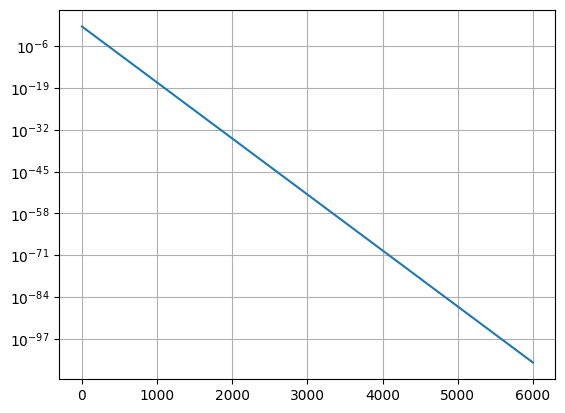

In [9]:
a = np.linspace(0, 6000, 500)
b = np.exp(-mu * a)
plt.plot(a, b)
plt.yscale('log')
plt.grid()

Our sum values are in the range of $1e^(7)$. Let's take $exp(-L_4)$ upto around $1e^(-7)$ range. Which is upto $L_4 = 345$. 

# Trying the same thing with PDFs (Normalized Histograms)

In [10]:
# comparing actual sum vs. histogram sum in EXP mode
mu = 0.04   # mm-1 (an expected value)
actual_sum = np.power(exp_neg_l4, mu).mean()
print("Actual sum: ", actual_sum)

dist, bin_edges = np.histogram(np.power(exp_neg_l4, mu), bins=100)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
dist = dist / np.sum(dist)
hist_sum = (dist * bin_centers).sum()
print("Histogram sum: ", hist_sum)

print("Error :", (np.abs(actual_sum - hist_sum) / actual_sum * 100), "%")

Actual sum:  0.8604741868917807
Histogram sum:  0.8567117459501147
Error : 0.4372520406750089 %


If you check the sum values, the error seemed to move from the 3rd most significant digit to the second. However, the % still remains the same. THis might be a little confusing but ultimately using PDFs do produce the same results as a histogram. 

# Defining Our Own Histogram Method
This is a test implementation to experiment around with. The actual implementation used for generating data is here **inverse_modelling_tfo/data_pipelines/custom_L4_hist.py**

In [11]:
def custom_hist_edge_generator(bin_count, max_val=345.):
    first_left_edge = 0.
    first_right_edge = 1.       # Resolution of 1mm -> No data captured should be less than 1mm
    last_right_edge = max_val
    middle_edges = np.logspace(np.log10(first_right_edge), np.log10(last_right_edge), num=bin_count, base=10.0)
    return np.concatenate(([first_left_edge], middle_edges))

a = custom_hist_edge_generator(10)
print(a)
print(len(a))

[  0.           1.           1.91416733   3.66403656   7.01357908
  13.42516394  25.69801021  49.19029156  94.15844902 180.23502687
 345.        ]
11


In [12]:
def custom_histogram(data, bin_count: int = 10, max_val: float = 345.):
    bin_edges = custom_hist_edge_generator(bin_count, max_val=max_val)
    temp_data = data[data <= max_val]   # Drop outliers on the right
    hist, _ = np.histogram(temp_data, bins=bin_edges)
    hist = hist / len(data)     # Normalize to sum to 1
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_centers[0] = 0.0    # Force the first bin center to be 0. Massively reduces the error! 
    return hist, bin_centers

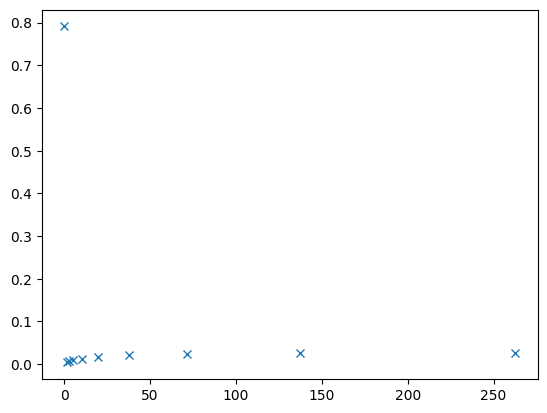

In [13]:
# Visualize the custom histogram
custom_bin_count = 10
hist, bin_centers = custom_histogram(l4_col, bin_count=custom_bin_count)
plt.plot(bin_centers, hist, 'x')

In [26]:
# Compare Error
histogram_sum = (hist * np.exp(-mu * bin_centers)).sum()
true_sum = np.exp(-mu * l4_col).mean()
print("Histogram sum: ", histogram_sum)
print("True sum: ", true_sum)
print("Error: ", f'{(np.abs(histogram_sum - true_sum) / true_sum * 100):1.2f}', "%")

Histogram sum:  0.8306062644118541
True sum:  0.8316144412553457
Error:  0.12 %


Which produces an even lower error than just storing the $exp(-\mu_a \times L_4)$ with an even lower number of bins! What's more is that the error can be controlled by changing the bin count and the max val. 

In [27]:
from typing import Tuple


def performance_check_custom_histogram(
    l4_data: pd.Series, mu: float = 0.04, bin_count: int = 10, max_val: float = 345.0
) -> Tuple[float, float, float]:
    """
    Compare the actual sum of the data with the sum of the histogram for a given dataset

    :param l4_data: The L4 data to be analyzed as a pandas Series
    :param mu: Absorption coefficient for the exponential distribution(Usually in the range of 0.02 to 0.08)
    :param bin_count: Number of bins to be used in the histogram(Default: 10)
    :param max_val: Maximum value to be considered in the histogram. Any pathlength beyond this is discarded
    (Default: 345mm)
    :return: A tuple of (percentage_error, histogram_sum, true_sum)
    """
    hist, bin_centers = custom_histogram(l4_data, bin_count=bin_count, max_val=max_val)
    histogram_sum = (hist * np.exp(-mu * bin_centers)).sum()
    true_sum = np.exp(-mu * l4_data).mean()
    prct_error = np.abs(histogram_sum - true_sum) / true_sum * 100
    return prct_error, histogram_sum, true_sum

In [28]:
def performance_check_numpy_histogram(
    l4_data: pd.Series, mu: float = 0.04, bin_count: int = 10, max_val: float = 345.0
) -> Tuple[float, float, float]:
    """
    Compare the actual sum of the data with the sum of the histogram for a given dataset

    :param l4_data: The L4 data to be analyzed as a pandas Series
    :param mu: Absorption coefficient for the exponential distribution(Usually in the range of 0.02 to 0.08)
    :param bin_count: Number of bins to be used in the histogram(Default: 10)
    :param max_val: Maximum value to be considered in the histogram. Any pathlength beyond this is discarded
    (Default: 345mm)
    :return: A tuple of (percentage_error, histogram_sum, true_sum)
    """
    l4_data = l4_data[l4_data <= max_val]
    dist, bin_edges = np.histogram(l4_data, bins=bin_count)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dist = dist / len(l4_data)      # Normalize histogram
    histogram_sum = (dist * np.exp(-mu * bin_centers)).sum()
    true_sum = np.exp(-mu * l4_data).mean()
    prct_error = np.abs(histogram_sum - true_sum) / true_sum * 100
    return prct_error, histogram_sum, true_sum

# Performance Test For Our Custom Histogram (Over the Entire Dataset)
Plots the error values for our histogram creater (in terms of the exponential sum)

In [31]:
error_df1 = pd.DataFrame(columns=['Percent Error', 'Histogram Sum', 'True Sum', 'Wave Length', 'Maternal Wall Thickness'])
error_df2 = pd.DataFrame(columns=['Percent Error', 'Histogram Sum', 'True Sum', 'Wave Length', 'Maternal Wall Thickness'])
chosen_sdd = 19
custom_bin_count = 10

for file in raw_files:
    raw_data = pd.read_pickle(file)
    config_file = file.with_suffix('.json')
    with open(config_file) as f:
        config_data = json.load(f)
    sdd_col = generate_sdd_column(raw_data).astype(int)
    raw_data = raw_data[sdd_col == chosen_sdd]
    raw_data = raw_data['L4 ppath']
    error1, hist_sum1, true_sum1 = performance_check_custom_histogram(raw_data, mu=0.04, bin_count=custom_bin_count)
    error2, hist_sum2, true_sum2 = performance_check_numpy_histogram(raw_data, mu=0.04, bin_count=custom_bin_count)
    wave_int = 735 if config_data['wave_int'] == 1 else 850
    maternal_wall_thickness = config_data['dermis_thickness']
    new_row1 = {'Percent Error': error1, 'Histogram Sum': hist_sum1, 'True Sum': true_sum1,
               'Wave Length': wave_int, 'Maternal Wall Thickness': maternal_wall_thickness}
    new_row2 = {'Percent Error': error2, 'Histogram Sum': hist_sum2, 'True Sum': true_sum2,
                'Wave Length': wave_int, 'Maternal Wall Thickness': maternal_wall_thickness}
    error_df1 = pd.concat([error_df1, pd.DataFrame([new_row1])], axis=0, ignore_index=True)
    error_df2 = pd.concat([error_df2, pd.DataFrame([new_row2])], axis=0, ignore_index=True)


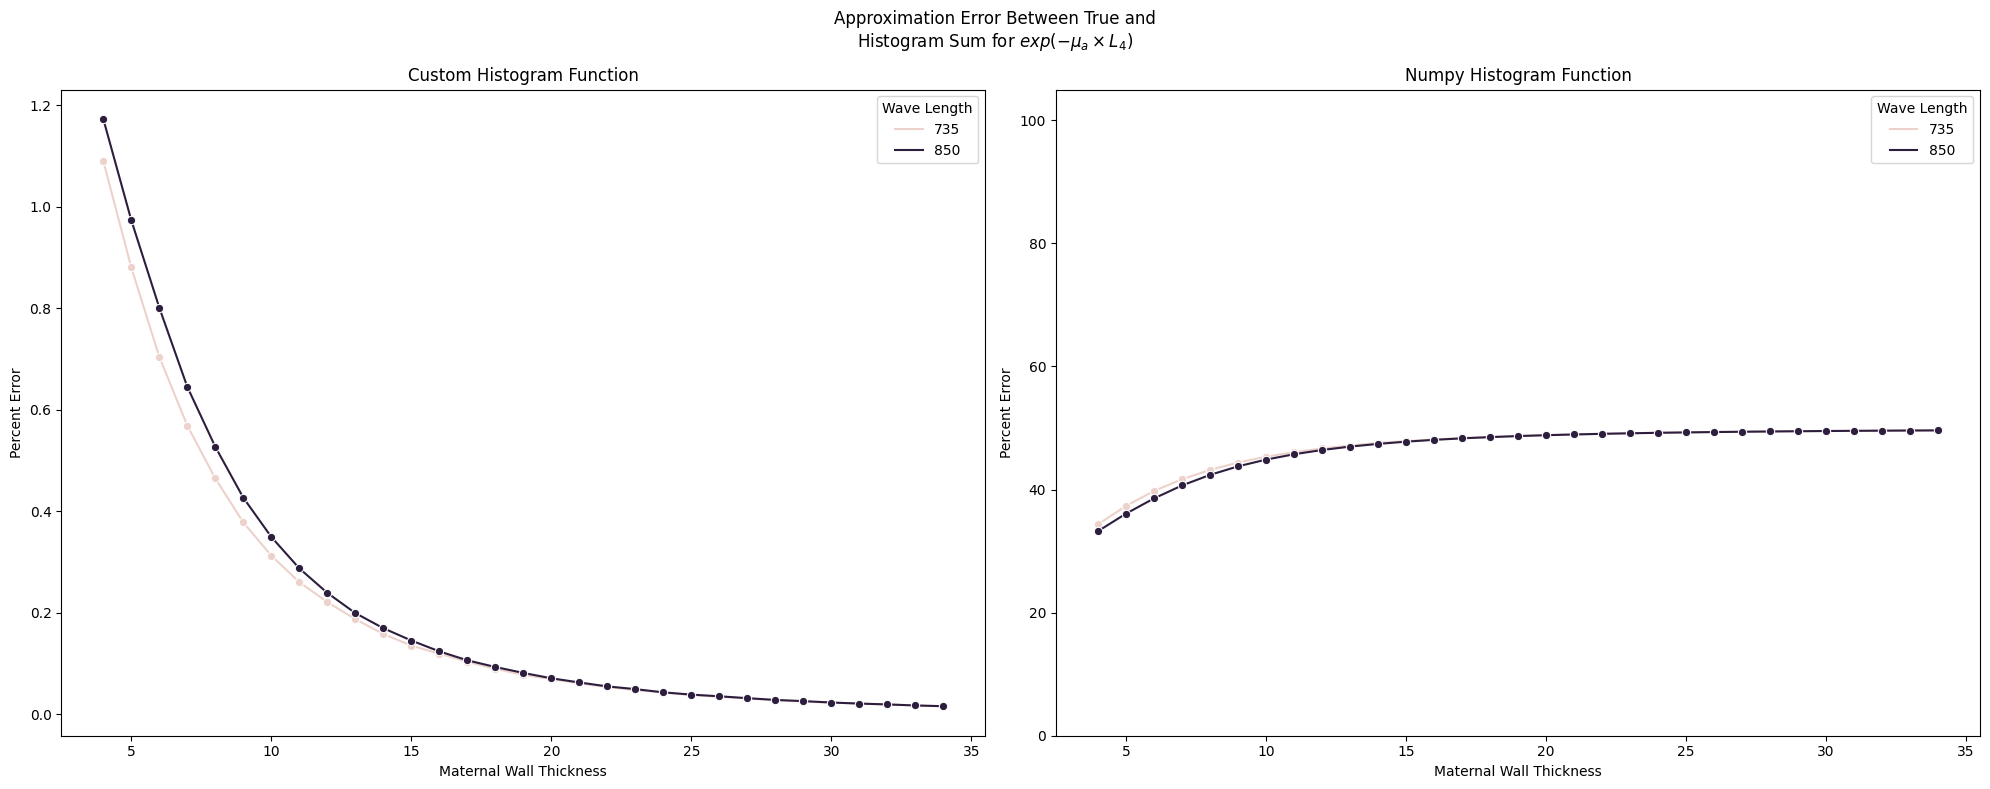

In [32]:
# Plotting the error vs. wave intensity
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
plt.suptitle(r"Approximation Error Between True and" "\n" r"Histogram Sum for $exp(-\mu_a \times L_4)$")
plt.sca(axes[0])
sns.lineplot(data=error_df1, x='Maternal Wall Thickness', y='Percent Error', marker='o', hue='Wave Length')
plt.title("Custom Histogram Function")

plt.sca(axes[1])
sns.lineplot(data=error_df2, x='Maternal Wall Thickness', y='Percent Error', marker='o', hue='Wave Length')
plt.ylim(0, 105)
plt.title("Numpy Histogram Function")

plt.tight_layout()

lol this makes a good plot XD

## Notes:
1. The histogram bins DO NOT add up to 1. A bunch photons with pathlength greater than the max_val are automatically discarded. But the histogram is normalized with the total number of photons before discarding rather than after. This keeps the accuracy competitive. If we were to make them sum upto 1, the accuracy falls significantly!
2. Accuracy increases with depth. The reason being the choice of max_val i.e, the length thresholding. If you decrease it, the error goes down marginally. 